# Paper - Example 2

## Initialization

In [1]:
# Import the pyKasso and numpy packages
import pykasso as pk
import numpy as np

# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0': 0,
    'y0': 0,
    'z0': 0,
    'nx': 100,
    'ny': 100,
    'nz': 50,
    'dx': 10,
    'dy': 10,
    'dz': 10,
}

# Declare the project parameters
app.new_project(name='example_02', grid_parameters=grid_parameters)

# Misc
app.visualizer.notebook = True
extent = app.project.grid.extent
imshow_options = {'extent': extent}

### Bedrock

Figure(fig=<Figure size 640x480 with 1 Axes>, ax=<Axes: xlabel='x', ylabel='y'>, cbar=None)

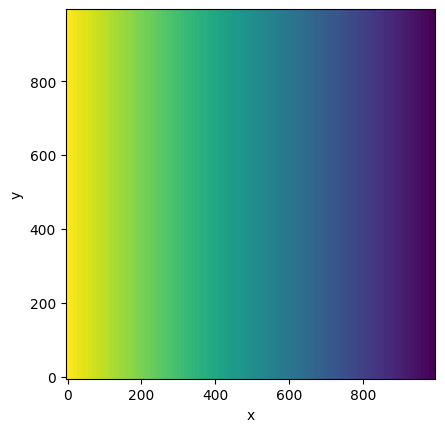

In [2]:
# Construct the bedrock elevation
bedrock = np.linspace(300, 100, grid_parameters['nx'])
bedrock = np.repeat(bedrock[:, np.newaxis], grid_parameters['ny'], axis=1)
app.visualizer.mpl_plot_array_2D(bedrock, imshow_options=imshow_options)

### Water table

Figure(fig=<Figure size 640x480 with 1 Axes>, ax=<Axes: xlabel='x', ylabel='y'>, cbar=None)

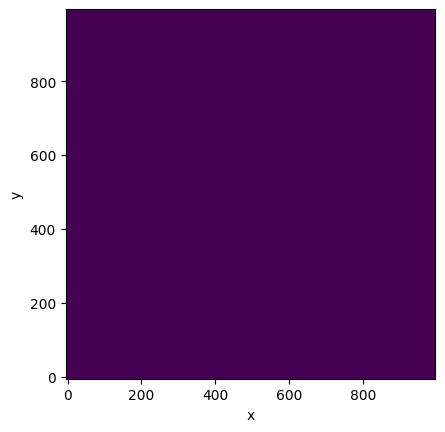

In [3]:
# Construct the water table
grid_shape = app.project.grid.shape[:2]
water_table = np.full(grid_shape, 200)
app.visualizer.mpl_plot_array_2D(water_table, imshow_options=imshow_options)

### Set the model

In [4]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'seed' : 1,
    },
    'domain' : {
        'bedrock' : bedrock,
        'water_table' : water_table
    },
    'outlets' : {
        'seed' : 1,
        'number' : 1,
        'subdomain': 'bedrock_phreatic',
    },
    'inlets' : {
        'seed' : 1,
        'number': 10,
    }
}

## Compute

In [5]:
# Compute 1 simulation with isotropic and 1 simulation with anisotropic fast marching algortihm
for algorithm in ['Isotropic3', 'Riemann3']:
    model_parameters['sks']['algorithm'] = algorithm
    app.model.generate(model_parameters=model_parameters)

In [6]:
# settings = {
#     'mask_values': [0],
#     'surfaces_options' : {
#         'bedrock' : {'opacity':1, 'cmap': 'copper'},
#         'water_table' : {},
#     },
#     'inlets_options' : {},
#     'outlets_options' : {},
#     'show_scalar_bar' : False,
# }
# font_size = 12
# settings_1 = settings.copy()
# settings_1['text_options'] = {'text' : '(a)', 'font_size': font_size}
# settings_2 = settings.copy()
# settings_2['text_options'] = {'text' : '(b)', 'font_size': font_size}
# last_simulations = app.project.get_last_simulations(2)
# filename = 'fig\example_02_iso_vs_ani.png'
# app.visualizer.pv_show(
#     simulations=last_simulations,
#     features=['karst'],
#     settings=[settings_1, settings_2],
#     cpos=[1, -1, 1],
#     window_size=(1000, 500),
#     zoom=1.4,
#     savefig=True,
#     filename=filename,
# )

In [7]:
# # Export the results in a html output
# plotter = app.visualizer.pv_show(simulations=last_simulations,
#                                  features=['karst'],
#                                  settings=[settings_1, settings_2],
#                                  cpos=[1, -1, 1],
#                                  return_plotter=True,)
# plotter.export_html('example_02.html')

In [8]:
df = app.analyzer.compute_metrics()
app.analyzer.compare_metrics(df)

,mean length,cv length,length entropy,tortuosity,orientation entropy,aspl,cpd,mean degree,cv degree,correlation vertex degree
0,189.152899,1.569892,0.463747,1.096605,0.719725,7.072546,0.377283,2.473684,0.503836,-0.551887
1,301.237001,1.364088,0.642499,1.146600,0.711211,5.307882,0.352608,2.275862,0.496792,-0.432292
